In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline
import sys
from os.path import join
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from keras import layers, Input, models
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True 

sess = tf.Session(config=config)
set_session(sess)  

Using TensorFlow backend.


In [2]:
datax = pd.read_csv('./train.csv')
datay = pd.read_csv('./target.csv',names=['label'])

In [3]:
dataEnt = pd.concat([datax, datay], axis=1)
dataL1= dataEnt[dataEnt['label'].isin(['1'])]
del dataL1['label']
dataL1.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
13,70000,1,2,2,30,1,2,2,0,0,...,65701,66782,36137,36894,3200,0,3000,3000,1500,0
16,20000,1,1,2,24,0,0,2,2,2,...,17428,18338,17905,19104,3200,0,1500,0,1650,0
21,120000,2,2,1,39,-1,-1,-1,-1,-1,...,316,0,632,316,316,316,0,632,316,0


In [4]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(dataL1)

df = dataL1.copy()

dataL1 = min_max_scaler.transform(dataL1)
dataL1 = pd.DataFrame(dataL1, columns=df.columns, index=list(df.index.values))
dataL1.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.013699,1.0,0.2,0.333333,0.055556,0.4,0.444444,0.1,0.1,0.0,...,0.097107,0.106276,0.088215,0.397393,0.000000,0.001921,0.000000,0.000000,0.000000,0.000000
1,0.150685,1.0,0.2,0.666667,0.092593,0.1,0.444444,0.2,0.2,0.2,...,0.100219,0.111612,0.093964,0.401209,0.000000,0.002788,0.001968,0.002314,0.000000,0.005792
13,0.082192,0.0,0.2,0.666667,0.166667,0.3,0.444444,0.4,0.2,0.2,...,0.198613,0.215186,0.148354,0.440565,0.010667,0.000000,0.005903,0.006942,0.004518,0.000000
16,0.013699,0.0,0.0,0.666667,0.055556,0.2,0.222222,0.4,0.4,0.4,...,0.123243,0.136182,0.118012,0.419748,0.010667,0.000000,0.002951,0.000000,0.004970,0.000000
21,0.150685,1.0,0.2,0.333333,0.333333,0.1,0.111111,0.1,0.1,0.1,...,0.096525,0.106276,0.089266,0.397762,0.001053,0.000881,0.000000,0.001463,0.000952,0.000000


In [5]:
epochs = 20000
batch_size = 1024
latent_dim = 100

dis_input_tensor = Input(shape = (23,))
dis_layer = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(dis_input_tensor)
dis_layer = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(dis_layer)

dis_output_tensor = layers.Dense(1, activation='sigmoid')(dis_layer)

discriminator = models.Model(dis_input_tensor, dis_output_tensor, name='Discriminator')
discriminator.compile(optimizer=Adam(0.0005,0.5), 
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
discriminator.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12288     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 143,873
Trainable params: 143,873
Non-trainable params: 0
_________________________________________________________________


In [6]:
gen_input_tensor = Input(shape = (latent_dim,))

gen_layer = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(gen_input_tensor)
gen_layer = layers.BatchNormalization(momentum=0.8)(gen_layer)
gen_layer = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(gen_layer)
gen_layer = layers.BatchNormalization(momentum=0.8)(gen_layer)
gen_output_tensor = layers.Dense(23, activation='sigmoid')(gen_layer)

generator = models.Model(gen_input_tensor, gen_output_tensor, name='Generator')

In [7]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 23)                11799     
Total params: 172,311
Trainable params: 170,775
Non-trainable params: 1,536
_________________________________________________________________


In [8]:
discriminator.trainable = False

z = Input((latent_dim, ), name = 'noise_input')
fake_data = generator(z)
validity = discriminator(fake_data)

combined_model = models.Model(z, validity, name='Combined_Model')

combined_model.compile(optimizer=Adam(0.001,0.5),
                       loss='binary_crossentropy',
                       )

In [9]:
combined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise_input (InputLayer)     (None, 100)               0         
_________________________________________________________________
Generator (Model)            (None, 23)                172311    
_________________________________________________________________
Discriminator (Model)        (None, 1)                 143873    
Total params: 316,184
Trainable params: 170,775
Non-trainable params: 145,409
_________________________________________________________________


In [10]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [11]:
step_size = len(dataL1)//batch_size

for epoch in range(epochs):
    for _ in range(step_size):
        for _ in range(3):
            idx = np.random.choice(dataL1.index, batch_size,False)
            data = dataL1.loc[idx]
            
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            
            gen_data = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(data, valid)
            
            d_loss_fake = discriminator.train_on_batch(gen_data, fake)
            
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        g_loss = combined_model.train_on_batch(noise, valid)
       

Instructions for updating:
Use tf.cast instead.


In [12]:
noise=np.random.normal(size=(20000,latent_dim))

In [13]:
generated_data=generator.predict(noise)

In [14]:
generated_data.shape

(20000, 23)

In [15]:
min_max_scaler.inverse_transform(generated_data)

array([[3.8592336e+04, 1.0000000e+00, 1.9938594e+00, ..., 1.1471632e+03,
        3.8902886e+03, 1.4124786e+02],
       [1.6512730e+05, 2.0000000e+00, 2.0026565e+00, ..., 2.3596589e+03,
        3.3232026e+03, 1.6303086e+03],
       [4.2433238e+04, 1.0000000e+00, 2.0001612e+00, ..., 7.3480731e+02,
        1.0371378e+03, 6.3067590e+02],
       ...,
       [1.7236467e+04, 2.0000000e+00, 2.0009933e+00, ..., 6.0255823e+02,
        8.1882849e+02, 4.1750751e+02],
       [5.6373742e+04, 2.0000000e+00, 1.9990450e+00, ..., 6.6982251e+02,
        6.7257977e+02, 1.1652177e+03],
       [8.2065570e+04, 2.0000000e+00, 2.0022111e+00, ..., 2.5834097e+03,
        2.0380326e+03, 2.2235476e+03]], dtype=float32)

In [16]:
type(data)

pandas.core.frame.DataFrame

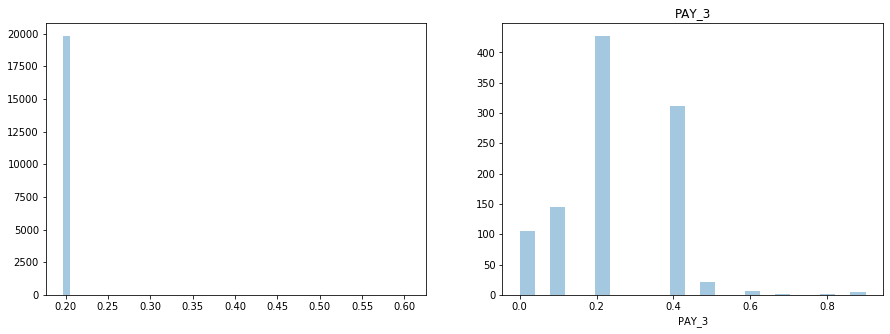

In [24]:
n=7
fig,ax=plt.subplots(1,2,figsize=(15,5))
sbn.distplot(generated_data[:,n],kde=False,ax=ax[0])
sbn.distplot(data.iloc[:,n],kde=False,ax=ax[1])
plt.title(data.keys()[n])
plt.show()

In [18]:
sbn.__version__

'0.9.0'

In [ ]:
df = generated_data